<a href="https://colab.research.google.com/github/Janoq25/Detecci-n-de-enfermedades-de-hojas-e-ma-z-con-deep-learning/blob/main/codigo%20clab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install fpdf rembg onnxruntime tensorflow keras scikit-learn streamlit matplotlib pandas numpy opencv-python keras-tuner


In [2]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

# Ruta a tu dataset original (donde están todas las imágenes por clase)
original_dataset_dir = '/content/drive/MyDrive/maize-leaf-disease/Data'

# Nueva ruta para almacenar el dataset dividido
base_dir = '/content/drive/MyDrive/maize-leaf-disease/Data2'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Crear carpetas de salida
for folder in [train_dir, val_dir]:
    os.makedirs(folder, exist_ok=True)

# Parámetro de división
split_ratio = 0.8  # 80% train, 20% val

# Procesar cada clase
classes = os.listdir(original_dataset_dir)

for class_name in classes:
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Crear carpetas de clase
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Copiar imágenes
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

    print(f'Clase {class_name}: {len(train_images)} entrenamiento, {len(val_images)} validación')

print("✅ División completa.")

Clase Common_rust_: 953 entrenamiento, 239 validación
Clase Cercospora_leaf_spot: 410 entrenamiento, 103 validación
Clase Northern_Leaf_Blight: 788 entrenamiento, 197 validación
Clase healthy: 929 entrenamiento, 233 validación
✅ División completa.


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_pre
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from google.colab import drive

from google.colab import drive
drive.mount('/content/drive')

# ------------------------
# 📂 Rutas y configuración general
# ------------------------
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/maize-leaf-disease"
train_dir = f"{base_path}/Data2/train"
val_dir = f"{base_path}/Data2/val"
report_path = f"{base_path}/Reports"
model_path = f"{base_path}/Models"
os.makedirs(report_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# ------------------------
# ⚙️ Carga de datos
# ------------------------
img_size = 128
batch_size = 32

# Cargar nombres de clases
temp_gen = ImageDataGenerator(preprocessing_function=mobilenet_pre)
temp_data = temp_gen.flow_from_directory(train_dir, target_size=(img_size, img_size))
class_names = list(temp_data.class_indices.keys())
num_classes = len(class_names)

# ------------------------
# 🔄 Generadores de datos
# ------------------------
def get_data_generators(preprocess_fn):
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),
        fill_mode='nearest'
    )
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_data = train_gen.flow_from_directory(train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical')
    val_data = val_gen.flow_from_directory(val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=False)

    return train_data, val_data

# ------------------------
# ⚖️ Construcción de modelos
# ------------------------
def build_model(base_model_fn, preprocess_fn, name):
    base_model = base_model_fn(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output, name=name)
    return model

# ------------------------
# 🔢 Entrenamiento y evaluación
# ------------------------
def train_and_evaluate(model_fn, preprocess_fn, model_name):
    print(f"\n======== Entrenando {model_name} ========")
    model = build_model(model_fn, preprocess_fn, model_name)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_data, val_data = get_data_generators(preprocess_fn)

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.3, verbose=1)
    ]

    start = time.time()
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        callbacks=callbacks
    )
    duration = time.time() - start
    print(f"\u23f1 Tiempo de entrenamiento: {duration:.2f} segundos")

    # Guardar modelo
    model.save(os.path.join(model_path, f"{model_name}.h5"))

    # Evaluación
    val_data.reset()
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Guardar reporte
    with open(os.path.join(report_path, f"{model_name}_report.txt"), "w") as f:
        f.write(classification_report(y_true, y_pred, target_names=class_names))

    # Guardar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.ylabel("Real")
    plt.xlabel("Predicho")
    plt.savefig(os.path.join(report_path, f"{model_name}_confusion_matrix.png"))
    plt.close()

# ------------------------
# 📈 Entrenar todos los modelos
# ------------------------
modelos = [
    (MobileNetV2, mobilenet_pre, "MobileNetV2"),
    (ResNet50, resnet_pre, "ResNet50"),
    (EfficientNetB0, efficientnet_pre, "EfficientNetB0")
]

for model_fn, preprocess_fn, name in modelos:
    train_and_evaluate(model_fn, preprocess_fn, name)

print("\n📅 Entrenamiento y evaluación completados.")



Mounted at /content/drive
Found 3080 images belonging to 4 classes.

======== Entrenando MobileNetV2 ========
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3080 images belonging to 4 classes.
Found 772 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 650s 6s/step - accuracy: 0.7521 - loss: 0.6055 - val_accuracy: 0.7720 - val_loss: 0.8622 - learning_rate: 1.0000e-04
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9395 - loss: 0.1531 - val_accuracy: 0.8679 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9629 - loss: 0.1051 - val_accuracy: 0.9262 - val_loss: 0.2583 - learning_rate: 1.0000e-04
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9633 - loss: 0.0984 - val_accuracy: 0.9197 - val_loss: 0.2923 - learning_rate: 1.0000e-04
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9806 - loss: 0.0584 - val_accuracy: 0.9365 - val_loss: 0.2733 - learning_rate: 1.0000e-04
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9807 - loss: 0.0517 - val_accuracy: 0.9378 - val_loss: 0.2088 - learning_rate: 1.0000e-04
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9859 

⏱ Tiempo de entrenamiento: 2818.43 segundos
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 643ms/step

======== Entrenando ResNet50 ========
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 3080 images belonging to 4 classes.
Found 772 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1045s 10s/step - accuracy: 0.7793 - loss: 0.5848 - val_accuracy: 0.9521 - val_loss: 0.2521 - learning_rate: 1.0000e-04
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 953s 10s/step - accuracy: 0.9534 - loss: 0.1336 - val_accuracy: 0.9728 - val_loss: 0.1021 - learning_rate: 1.0000e-04
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 969s 10s/step - accuracy: 0.9746 - loss: 0.0731 - val_accuracy: 0.9806 - val_loss: 0.0558 - learning_rate: 1.0000e-04
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 974s 10s/step - accuracy: 0.9780 - loss: 0.0623 - val_accuracy: 0.9832 - val_loss: 0.0528 - learning_rate: 1.0000e-04
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 949s 10s/step - accuracy: 0.9793 - loss: 0.0453 - val_accuracy: 0.9909 - val_loss: 0.0347 - learning_rate: 1.0000e-04
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 987s 10s/step - accuracy: 0.9899 - loss: 0.0335 - val_accuracy: 0.9275 - val_loss: 0.1922 - learning_rate: 1.0000e-04
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 996s 10s/step - accuracy:

⏱ Tiempo de entrenamiento: 9768.24 segundos
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

======== Entrenando EfficientNetB0 ========
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3080 images belonging to 4 classes.
Found 772 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.6320 - loss: 0.8828 - val_accuracy: 0.9093 - val_loss: 0.2261 - learning_rate: 1.0000e-04
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9198 - loss: 0.2092 - val_accuracy: 0.9663 - val_loss: 0.1114 - learning_rate: 1.0000e-04
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9538 - loss: 0.1320 - val_accuracy: 0.9780 - val_loss: 0.0698 - learning_rate: 1.0000e-04
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9588 - loss: 0.1191 - val_accuracy: 0.9819 - val_loss: 0.0610 - learning_rate: 1.0000e-04
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.9707 - loss: 0.0791 - val_accuracy: 0.9832 - val_loss: 0.0515 - learning_rate: 1.0000e-04
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9732 - loss: 0.0712 - val_accuracy: 0.9858 - val_loss: 0.0506 - learning_rate: 1.0000e-04
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9802 

⏱ Tiempo de entrenamiento: 3336.92 segundos
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 871ms/step

📅 Entrenamiento y evaluación completados.


NameError: name 'resultados' is not defined

🚀 Generando reportes desde modelos guardados...
🔍 Buscando modelos guardados...
✅ Encontrado: MobileNetV2.h5


✅ Encontrado: ResNet50.h5


✅ Encontrado: EfficientNetB0.h5


Found 772 images belonging to 4 classes.
Found 772 images belonging to 4 classes.
Found 772 images belonging to 4 classes.

📊 Evaluando modelos...

🔄 Evaluando MobileNetV2...
✅ MobileNetV2: Accuracy = 0.9573, MCC = 0.9419

🔄 Evaluando ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ ResNet50: Accuracy = 0.9909, MCC = 0.9876

🔄 Evaluando EfficientNetB0...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ EfficientNetB0: Accuracy = 0.9819, MCC = 0.9752

🔬 Realizando pruebas de McNemar...
📊 MobileNetV2 vs ResNet50: p-value = 0.0000
📊 MobileNetV2 vs EfficientNetB0: p-value = 0.0017
📊 ResNet50 vs EfficientNetB0: p-value = 0.0707


/tmp/ipython-input-9-483241913.py:292: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-9-483241913.py:293: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(f'{reports_dir}/modelos_comparacion_completa.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


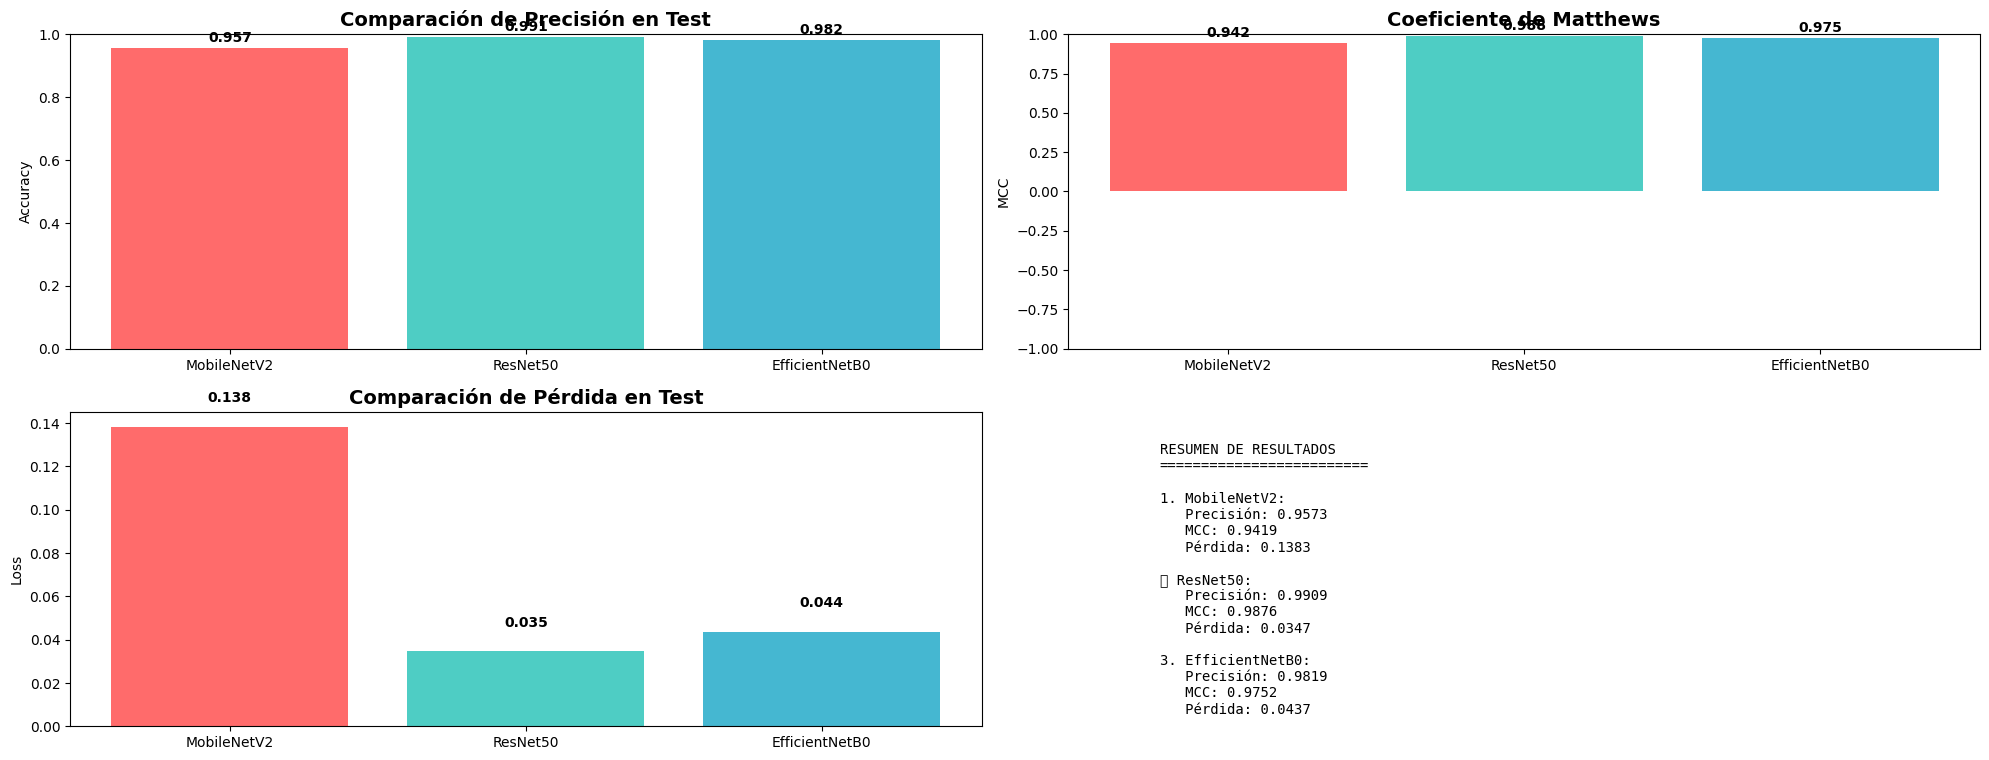

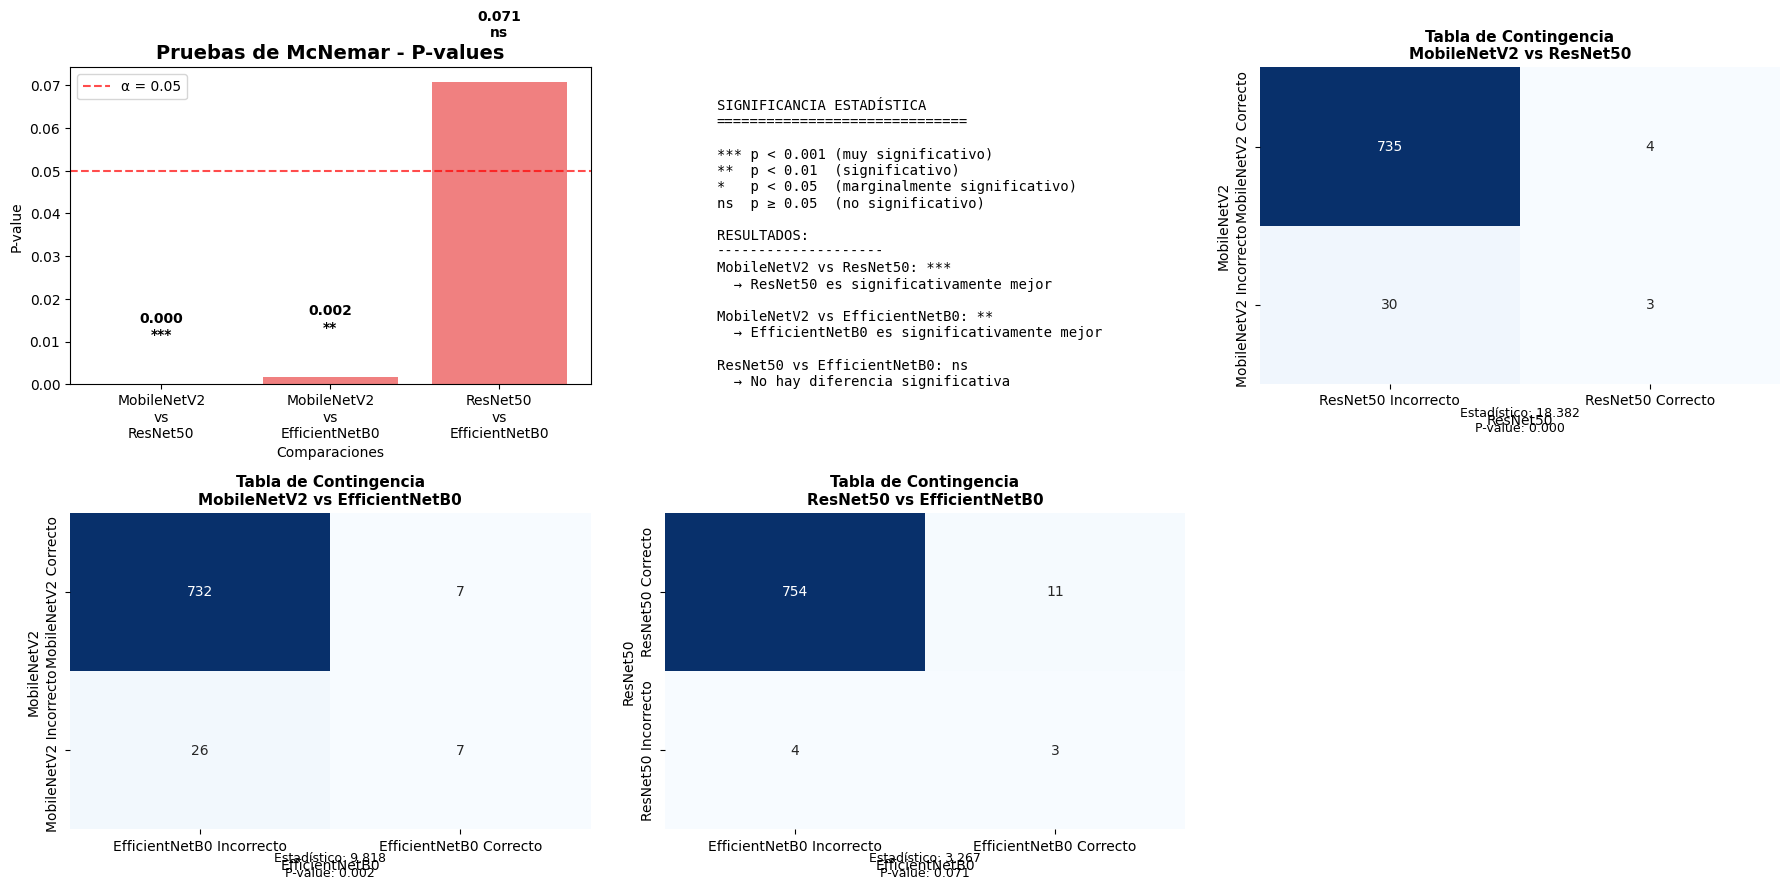

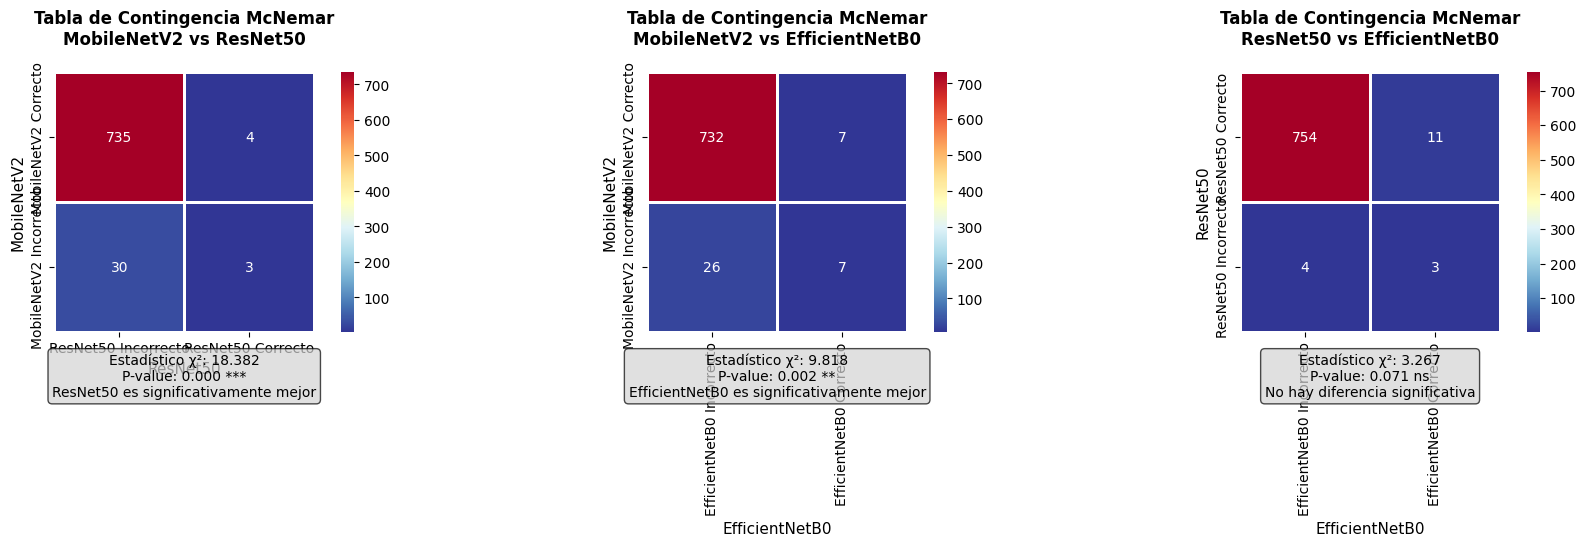

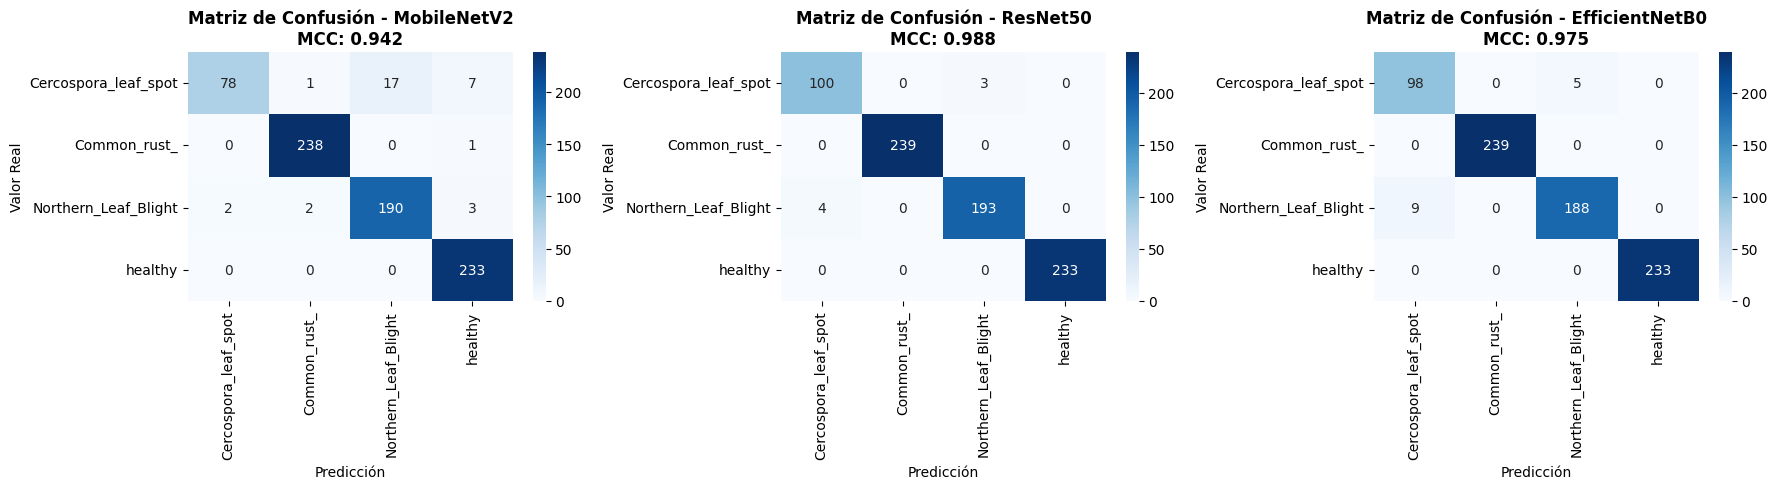

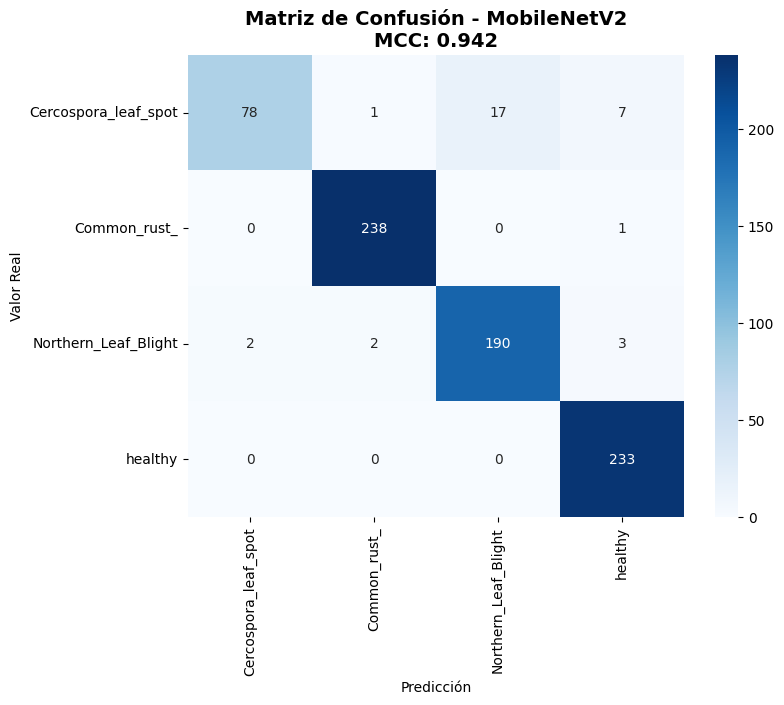

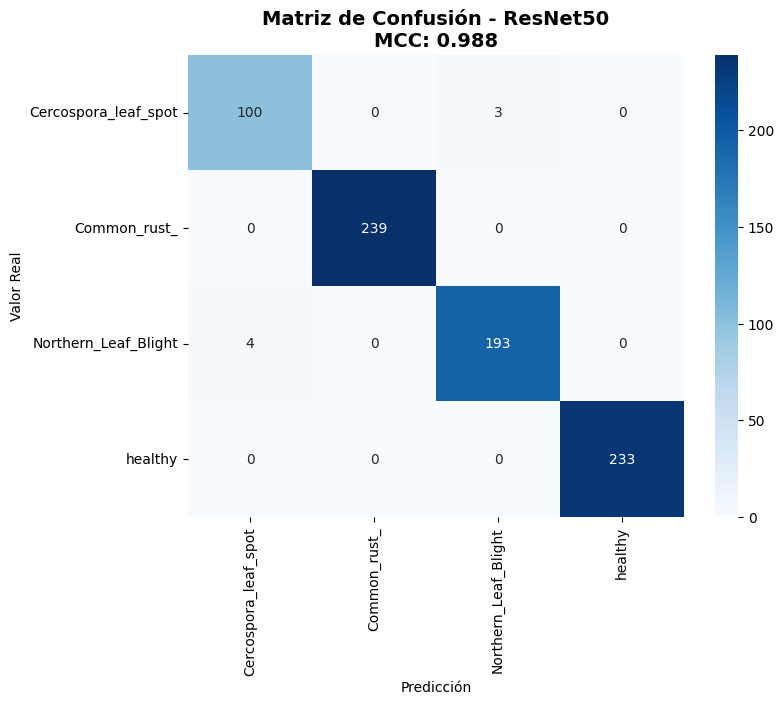

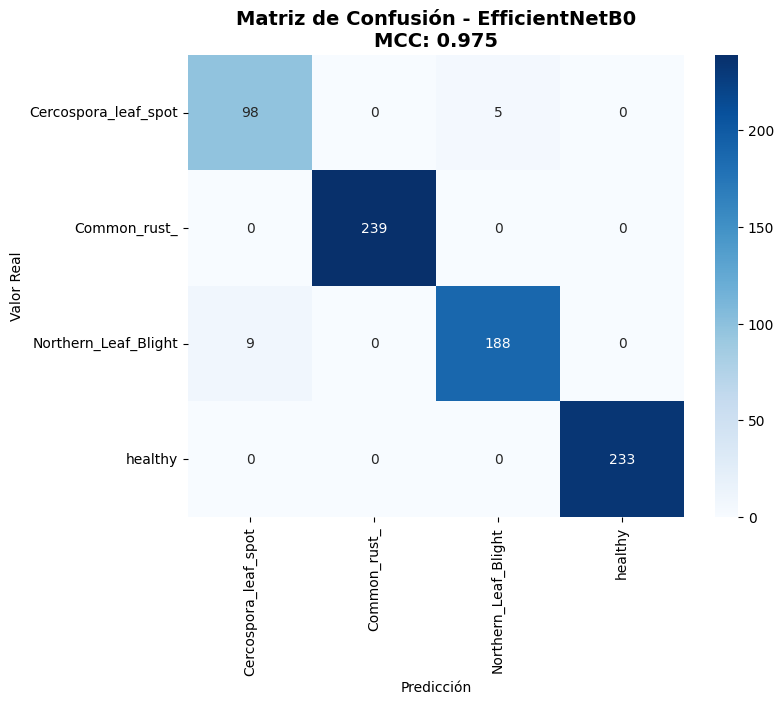

<Figure size 1500x1000 with 0 Axes>

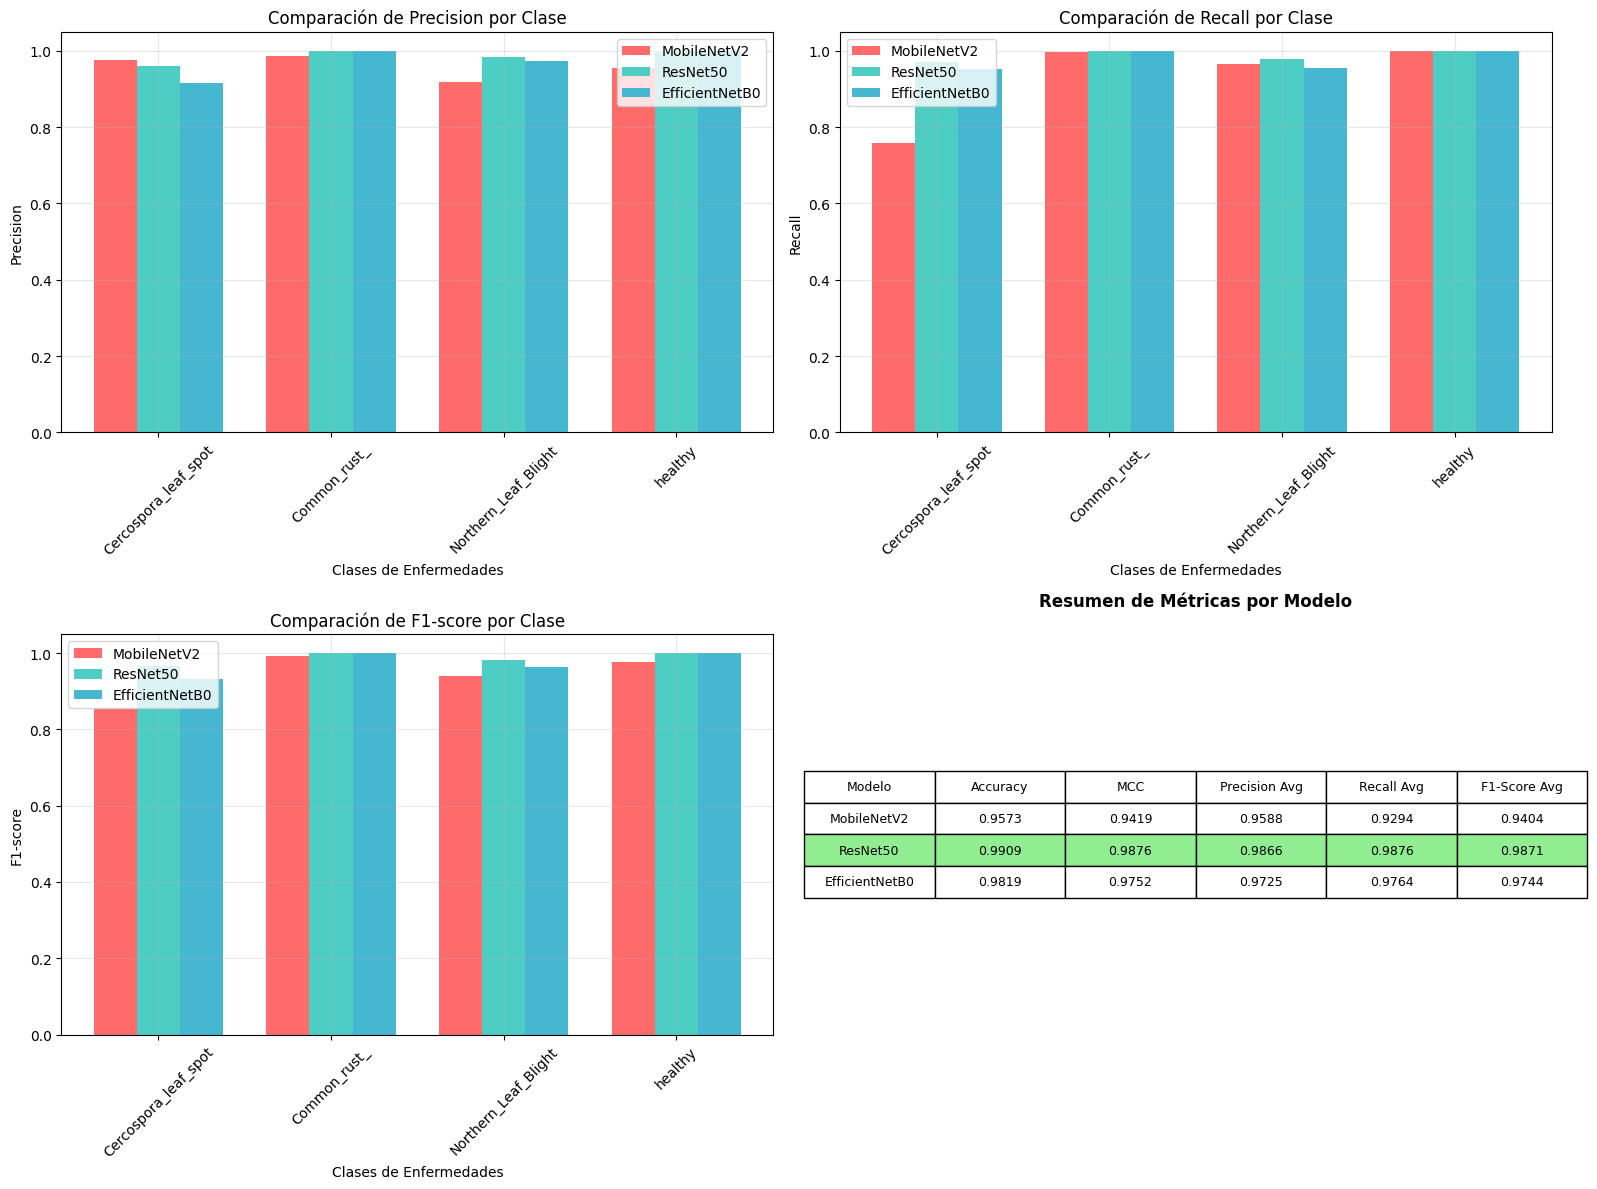

📈 Reportes generados exitosamente:
   - Comparación completa: /content/drive/MyDrive/maize-leaf-disease/Reports2/modelos_comparacion_completa.png
   - Análisis McNemar: /content/drive/MyDrive/maize-leaf-disease/Reports2/mcnemar_analysis.png
   - Tablas de contingencia McNemar: /content/drive/MyDrive/maize-leaf-disease/Reports2/mcnemar_contingency_tables.png
   - Matrices de confusión: /content/drive/MyDrive/maize-leaf-disease/Reports2/matrices_confusion_todos.png
   - Métricas detalladas: /content/drive/MyDrive/maize-leaf-disease/Reports2/metricas_detalladas_por_clase.png
   - Reporte de texto: /content/drive/MyDrive/maize-leaf-disease/Reports2/reporte_completo.txt
   - Matriz individual MobileNetV2: /content/drive/MyDrive/maize-leaf-disease/Reports2/matriz_confusion_mobilenetv2.png
   - Matriz individual ResNet50: /content/drive/MyDrive/maize-leaf-disease/Reports2/matriz_confusion_resnet50.png
   - Matriz individual EfficientNetB0: /content/drive/MyDrive/maize-leaf-disease/Reports2/ma

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import os
import pickle
from itertools import combinations

# Configuración
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 4

# Definir las enfermedades (ajusta según tu dataset)
DISEASES = {
    'Blight': 'Tizón',
    'Common_Rust': 'Roya Común',
    'Gray_Leaf_Spot': 'Mancha Gris',
    'Healthy': 'Saludable'
}

# Rutas
models_dir = '/content/drive/MyDrive/maize-leaf-disease/Models'
reports_dir = '/content/drive/MyDrive/maize-leaf-disease/Reports2'
test_dir = '/content/drive/MyDrive/maize-leaf-disease/Data2/val'  # Usando val como test

# Crear directorio de reportes
os.makedirs(reports_dir, exist_ok=True)

# Coeficiente de Matthews
def matthews_corrcoef(cm):
    """Calcular el coeficiente de Matthews para matriz de confusión multiclase"""
    if cm.shape[0] == 2:  # Caso binario
        tp, fp, fn, tn = cm[1][1], cm[0][1], cm[1][0], cm[0][0]
        numerator = (tp * tn) - (fp * fn)
        denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        return numerator / denominator if denominator != 0 else 0
    else:  # Caso multiclase
        # Implementación para multiclase basada en la definición original
        n = cm.shape[0]
        sum_p = np.sum(cm, axis=1)  # Suma por filas (predicciones)
        sum_t = np.sum(cm, axis=0)  # Suma por columnas (verdaderos)
        c = np.trace(cm)  # Suma diagonal (correctas)
        s = np.sum(cm)  # Total de muestras

        numerator = c * s - np.dot(sum_p, sum_t)
        denominator = np.sqrt((s**2 - np.dot(sum_p, sum_p)) * (s**2 - np.dot(sum_t, sum_t)))

        return numerator / denominator if denominator != 0 else 0

# Prueba de McNemar
def mcnemar_test(y_true, y_model1, y_model2):
    """Prueba de McNemar para comparar dos modelos"""
    # Crear tabla de contingencia
    table = np.zeros((2, 2))
    for true, pred1, pred2 in zip(y_true, y_model1, y_model2):
        if pred1 == true and pred2 != true:
            table[0][1] += 1  # Modelo 1 correcto, Modelo 2 incorrecto
        elif pred1 != true and pred2 == true:
            table[1][0] += 1  # Modelo 1 incorrecto, Modelo 2 correcto
        elif pred1 == true and pred2 == true:
            table[0][0] += 1  # Ambos correctos
        else:
            table[1][1] += 1  # Ambos incorrectos

    # Calcular estadístico de McNemar
    if table[0][1] + table[1][0] > 25:  # Corrección de Yates para muestras grandes
        statistic = (np.abs(table[0][1] - table[1][0]) - 1)**2 / (table[0][1] + table[1][0])
    else:
        statistic = (np.abs(table[0][1] - table[1][0]))**2 / (table[0][1] + table[1][0])

    if table[0][1] + table[1][0] == 0:
        p_value = 1.0  # No hay diferencias
    else:
        p_value = 1 - stats.chi2.cdf(statistic, df=1)

    return statistic, p_value, table

def load_saved_models():
    """Cargar todos los modelos guardados"""
    models = {}

    # Buscar archivos de modelos
    model_files = {
        'MobileNetV2': 'MobileNetV2.h5',
        'ResNet50': 'ResNet50.h5',
        'EfficientNetB0': 'EfficientNetB0.h5'
    }

    # Intentar también con otros nombres posibles
    alternative_names = {
        'MobileNetV2': ['mobilenetv2_checkpoint.h5', 'MobileNetV2_best.h5'],
        'ResNet50': ['resnet50_checkpoint.h5', 'ResNet50_best.h5'],
        'EfficientNetB0': ['efficientnetb0_checkpoint.h5', 'EfficientNetB0_best.h5']
    }

    print("🔍 Buscando modelos guardados...")

    for model_name, filename in model_files.items():
        model_path = os.path.join(models_dir, filename)

        if os.path.exists(model_path):
            print(f"✅ Encontrado: {filename}")
            models[model_name] = tf.keras.models.load_model(model_path)
        else:
            # Buscar nombres alternativos
            found = False
            for alt_name in alternative_names[model_name]:
                alt_path = os.path.join(models_dir, alt_name)
                if os.path.exists(alt_path):
                    print(f"✅ Encontrado: {alt_name}")
                    models[model_name] = tf.keras.models.load_model(alt_path)
                    found = True
                    break

            if not found:
                print(f"❌ No encontrado: {model_name}")

    return models

def create_test_generators():
    """Crear generadores de datos para evaluación"""
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    generators = {}

    # Generadores para cada tipo de preprocesamiento
    datagens = {
        "MobileNetV2": ImageDataGenerator(preprocessing_function=mobilenet_preprocess),
        "ResNet50": ImageDataGenerator(preprocessing_function=resnet_preprocess),
        "EfficientNetB0": ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
    }

    for model_name, datagen in datagens.items():
        test_gen = datagen.flow_from_directory(
            test_dir,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False  # Importante para mantener orden
        )
        generators[model_name] = test_gen

    return generators

def evaluate_models(models, generators):
    """Evaluar todos los modelos y obtener métricas"""
    results = {}
    all_predictions = {}  # Para almacenar predicciones de todos los modelos

    print("\n📊 Evaluando modelos...")

    for model_name, model in models.items():
        print(f"\n🔄 Evaluando {model_name}...")

        test_gen = generators[model_name]
        test_gen.reset()  # Reiniciar generador

        # Evaluación básica
        test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)

        # Predicciones
        test_gen.reset()
        predictions = model.predict(test_gen, verbose=0)
        y_pred = np.argmax(predictions, axis=1)

        # Etiquetas verdaderas
        y_true = test_gen.classes

        # Matriz de confusión
        cm = confusion_matrix(y_true, y_pred)

        # Coeficiente de Matthews
        mcc = matthews_corrcoef(cm)

        # Reporte de clasificación
        class_names = list(test_gen.class_indices.keys())
        report = classification_report(y_true, y_pred,
                                     target_names=class_names,
                                     output_dict=True)

        results[model_name] = {
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'confusion_matrix': cm,
            'classification_report': report,
            'class_names': class_names,
            'matthews_corrcoef': mcc,
            'y_true': y_true,
            'y_pred': y_pred
        }

        all_predictions[model_name] = y_pred

        print(f"✅ {model_name}: Accuracy = {test_accuracy:.4f}, MCC = {mcc:.4f}")

    # Realizar pruebas de McNemar entre todos los pares de modelos
    mcnemar_results = {}
    model_names = list(models.keys())

    if len(model_names) > 1:
        print("\n🔬 Realizando pruebas de McNemar...")

        for model1, model2 in combinations(model_names, 2):
            y_true = results[model1]['y_true']  # Mismo y_true para todos
            y_pred1 = results[model1]['y_pred']
            y_pred2 = results[model2]['y_pred']

            statistic, p_value, table = mcnemar_test(y_true, y_pred1, y_pred2)

            mcnemar_results[f"{model1}_vs_{model2}"] = {
                'statistic': statistic,
                'p_value': p_value,
                'contingency_table': table,
                'model1': model1,
                'model2': model2
            }

            print(f"📊 {model1} vs {model2}: p-value = {p_value:.4f}")

    return results, mcnemar_results

def generate_comprehensive_reports(results, mcnemar_results):
    """Generar todos los reportes visuales y de texto"""

    # 1. Comparación general de modelos (incluyendo MCC)
    plt.figure(figsize=(20, 8))

    # Subplot 1: Precisión
    plt.subplot(2, 2, 1)
    model_names = list(results.keys())
    accuracies = [results[name]['test_accuracy'] for name in model_names]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA726', '#AB47BC']
    bars = plt.bar(model_names, accuracies, color=colors[:len(model_names)])
    plt.title('Comparación de Precisión en Test', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Añadir valores sobre las barras
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # Subplot 2: Coeficiente de Matthews
    plt.subplot(2, 2, 2)
    mcc_values = [results[name]['matthews_corrcoef'] for name in model_names]
    bars = plt.bar(model_names, mcc_values, color=colors[:len(model_names)])
    plt.title('Coeficiente de Matthews', fontsize=14, fontweight='bold')
    plt.ylabel('MCC')
    plt.ylim(-1, 1)

    # Añadir valores sobre las barras
    for bar, mcc in zip(bars, mcc_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{mcc:.3f}', ha='center', va='bottom', fontweight='bold')

    # Subplot 3: Pérdida
    plt.subplot(2, 2, 3)
    losses = [results[name]['test_loss'] for name in model_names]
    bars = plt.bar(model_names, losses, color=colors[:len(model_names)])
    plt.title('Comparación de Pérdida en Test', fontsize=14, fontweight='bold')
    plt.ylabel('Loss')

    # Añadir valores sobre las barras
    for bar, loss in zip(bars, losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{loss:.3f}', ha='center', va='bottom', fontweight='bold')

    # Subplot 4: Resumen de métricas
    plt.subplot(2, 2, 4)
    plt.axis('off')

    # Crear tabla de resumen
    summary_text = "RESUMEN DE RESULTADOS\n" + "="*25 + "\n\n"
    best_model = max(results, key=lambda x: results[x]['test_accuracy'])

    for i, (name, result) in enumerate(results.items()):
        marker = "🏆 " if name == best_model else f"{i+1}. "
        summary_text += f"{marker}{name}:\n"
        summary_text += f"   Precisión: {result['test_accuracy']:.4f}\n"
        summary_text += f"   MCC: {result['matthews_corrcoef']:.4f}\n"
        summary_text += f"   Pérdida: {result['test_loss']:.4f}\n\n"

    plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.savefig(f'{reports_dir}/modelos_comparacion_completa.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Gráfico de pruebas de McNemar
    if mcnemar_results:
        # Crear figura para tablas de contingencia
        n_comparisons = len(mcnemar_results)
        fig_height = max(8, n_comparisons * 3)
        plt.figure(figsize=(18, fig_height))

        # Subplot 1: P-values de McNemar
        plt.subplot(2, 3, 1)
        comparisons = list(mcnemar_results.keys())
        p_values = [mcnemar_results[comp]['p_value'] for comp in comparisons]

        bars = plt.bar(range(len(comparisons)), p_values, color='lightcoral')
        plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α = 0.05')
        plt.title('Pruebas de McNemar - P-values', fontsize=14, fontweight='bold')
        plt.ylabel('P-value')
        plt.xlabel('Comparaciones')
        plt.xticks(range(len(comparisons)), [comp.replace('_vs_', '\nvs\n') for comp in comparisons])
        plt.legend()

        # Añadir valores sobre las barras
        for bar, p_val in zip(bars, p_values):
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{p_val:.3f}\n{significance}', ha='center', va='bottom', fontweight='bold')

        # Subplot 2: Tabla de significancia
        plt.subplot(2, 3, 2)
        plt.axis('off')

        significance_text = "SIGNIFICANCIA ESTADÍSTICA\n" + "="*30 + "\n\n"
        significance_text += "*** p < 0.001 (muy significativo)\n"
        significance_text += "**  p < 0.01  (significativo)\n"
        significance_text += "*   p < 0.05  (marginalmente significativo)\n"
        significance_text += "ns  p ≥ 0.05  (no significativo)\n\n"

        significance_text += "RESULTADOS:\n" + "-"*20 + "\n"
        for comp, result in mcnemar_results.items():
            model1, model2 = result['model1'], result['model2']
            p_val = result['p_value']
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"

            # Determinar cuál modelo es mejor
            acc1 = results[model1]['test_accuracy']
            acc2 = results[model2]['test_accuracy']
            better = model1 if acc1 > acc2 else model2

            significance_text += f"{model1} vs {model2}: {significance}\n"
            if p_val < 0.05:
                significance_text += f"  → {better} es significativamente mejor\n"
            else:
                significance_text += f"  → No hay diferencia significativa\n"
            significance_text += "\n"

        plt.text(0.1, 0.9, significance_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

        # Subplots 3-6: Tablas de contingencia individuales
        subplot_positions = [(2, 3, 3), (2, 3, 4), (2, 3, 5), (2, 3, 6)]

        for idx, (comp, result) in enumerate(mcnemar_results.items()):
            if idx < len(subplot_positions):
                plt.subplot(*subplot_positions[idx])

                table = result['contingency_table']
                model1, model2 = result['model1'], result['model2']

                # Crear heatmap de la tabla de contingencia
                sns.heatmap(table, annot=True, fmt='.0f', cmap='Blues',
                           xticklabels=[f'{model2} Incorrecto', f'{model2} Correcto'],
                           yticklabels=[f'{model1} Correcto', f'{model1} Incorrecto'],
                           cbar=False)

                plt.title(f'Tabla de Contingencia\n{model1} vs {model2}',
                         fontsize=11, fontweight='bold')
                plt.xlabel(f'{model2}')
                plt.ylabel(f'{model1}')

                # Añadir información adicional
                p_val = result['p_value']
                statistic = result['statistic']
                plt.text(0.5, -0.15, f'Estadístico: {statistic:.3f}\nP-value: {p_val:.3f}',
                        transform=plt.gca().transAxes, ha='center', fontsize=9)

        plt.tight_layout()
        plt.savefig(f'{reports_dir}/mcnemar_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Crear figura separada solo para las tablas de contingencia (más grande y clara)
        n_comparisons = len(mcnemar_results)
        cols = min(3, n_comparisons)
        rows = (n_comparisons + cols - 1) // cols

        plt.figure(figsize=(6*cols, 5*rows))

        for idx, (comp, result) in enumerate(mcnemar_results.items()):
            plt.subplot(rows, cols, idx + 1)

            table = result['contingency_table']
            model1, model2 = result['model1'], result['model2']

            # Crear heatmap más detallado
            ax = sns.heatmap(table, annot=True, fmt='.0f', cmap='RdYlBu_r',
                           xticklabels=[f'{model2} Incorrecto', f'{model2} Correcto'],
                           yticklabels=[f'{model1} Correcto', f'{model1} Incorrecto'],
                           cbar=True, square=True, linewidths=1)

            plt.title(f'Tabla de Contingencia McNemar\n{model1} vs {model2}',
                     fontsize=12, fontweight='bold', pad=20)
            plt.xlabel(f'{model2}', fontsize=11)
            plt.ylabel(f'{model1}', fontsize=11)

            # Añadir información estadística
            p_val = result['p_value']
            statistic = result['statistic']
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"

            info_text = f'Estadístico χ²: {statistic:.3f}\nP-value: {p_val:.3f} {significance}'
            if p_val < 0.05:
                acc1 = results[model1]['test_accuracy']
                acc2 = results[model2]['test_accuracy']
                better = model1 if acc1 > acc2 else model2
                info_text += f'\n{better} es significativamente mejor'
            else:
                info_text += f'\nNo hay diferencia significativa'

            plt.text(0.5, -0.25, info_text, transform=plt.gca().transAxes,
                    ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3",
                    facecolor="lightgray", alpha=0.7))

        plt.tight_layout()
        plt.savefig(f'{reports_dir}/mcnemar_contingency_tables.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 3. Matrices de confusión individuales
    fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))
    if len(results) == 1:
        axes = [axes]

    for idx, (name, result) in enumerate(results.items()):
        class_names = result['class_names']
        sns.heatmap(result['confusion_matrix'],
                   annot=True, fmt='d',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   cmap='Blues',
                   ax=axes[idx])
        axes[idx].set_title(f'Matriz de Confusión - {name}\nMCC: {result["matthews_corrcoef"]:.3f}',
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicción')
        axes[idx].set_ylabel('Valor Real')

    plt.tight_layout()
    plt.savefig(f'{reports_dir}/matrices_confusion_todos.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Matrices de confusión individuales (archivos separados)
    for name, result in results.items():
        plt.figure(figsize=(8, 6))
        class_names = result['class_names']
        sns.heatmap(result['confusion_matrix'],
                   annot=True, fmt='d',
                   xticklabels=class_names,
                   yticklabels=class_names,
                   cmap='Blues')
        plt.title(f'Matriz de Confusión - {name}\nMCC: {result["matthews_corrcoef"]:.3f}',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')

        # Guardar matriz individual
        filename = name.replace(' ', '_').lower()
        plt.savefig(f'{reports_dir}/matriz_confusion_{filename}.png', dpi=300, bbox_inches='tight')
        plt.show()

    # 5. Reporte detallado de clasificación
    plt.figure(figsize=(15, 10))

    # Crear métricas por clase para cada modelo
    classes = results[list(results.keys())[0]]['class_names']

    # Crear subplots para métricas por clase
    metrics = ['precision', 'recall', 'f1-score']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Gráfico por métrica
    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Preparar datos para el gráfico
        model_names = list(results.keys())
        x = np.arange(len(classes))
        width = 0.25

        for i, model_name in enumerate(model_names):
            values = []
            for class_name in classes:
                report = results[model_name]['classification_report']
                if class_name in report:
                    values.append(report[class_name][metric])
                else:
                    values.append(0)

            ax.bar(x + i*width, values, width, label=model_name,
                  color=colors[i] if i < len(colors) else '#999999')

        ax.set_xlabel('Clases de Enfermedades')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Comparación de {metric.capitalize()} por Clase')
        ax.set_xticks(x + width)
        ax.set_xticklabels(classes, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Tabla resumen en el cuarto subplot
    axes[3].axis('off')

    # Crear tabla de métricas generales
    table_data = []
    for name, result in results.items():
        report = result['classification_report']
        table_data.append([
            name,
            f"{result['test_accuracy']:.4f}",
            f"{result['matthews_corrcoef']:.4f}",
            f"{report['macro avg']['precision']:.4f}",
            f"{report['macro avg']['recall']:.4f}",
            f"{report['macro avg']['f1-score']:.4f}"
        ])

    # Crear tabla
    table = axes[3].table(cellText=table_data,
                         colLabels=['Modelo', 'Accuracy', 'MCC', 'Precision Avg', 'Recall Avg', 'F1-Score Avg'],
                         cellLoc='center',
                         loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 2)

    # Colorear la fila del mejor modelo
    best_model = max(results, key=lambda x: results[x]['test_accuracy'])
    best_idx = model_names.index(best_model)
    for col in range(6):
        table[(best_idx + 1, col)].set_facecolor('#90EE90')  # Verde claro

    axes[3].set_title('Resumen de Métricas por Modelo', fontsize=12, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(f'{reports_dir}/metricas_detalladas_por_clase.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 6. Guardar reporte de texto
    with open(f'{reports_dir}/reporte_completo.txt', 'w', encoding='utf-8') as f:
        f.write("REPORTE COMPLETO DE CLASIFICACIÓN DE ENFERMEDADES EN MAÍZ\n")
        f.write("="*60 + "\n\n")

        best_model = max(results, key=lambda x: results[x]['test_accuracy'])
        f.write(f"MEJOR MODELO: {best_model}\n")
        f.write(f"Precisión: {results[best_model]['test_accuracy']:.4f}\n")
        f.write(f"Coeficiente de Matthews: {results[best_model]['matthews_corrcoef']:.4f}\n\n")

        for name, result in results.items():
            f.write(f"\n{name.upper()}\n")
            f.write("-" * len(name) + "\n")
            f.write(f"Precisión en Test: {result['test_accuracy']:.4f}\n")
            f.write(f"Pérdida en Test: {result['test_loss']:.4f}\n")
            f.write(f"Coeficiente de Matthews: {result['matthews_corrcoef']:.4f}\n\n")

            f.write("Reporte de clasificación:\n")
            report = result['classification_report']
            classes = result['class_names']
            for class_name in classes:
                if class_name in report:
                    f.write(f"  {class_name}:\n")
                    f.write(f"    Precision: {report[class_name]['precision']:.4f}\n")
                    f.write(f"    Recall: {report[class_name]['recall']:.4f}\n")
                    f.write(f"    F1-Score: {report[class_name]['f1-score']:.4f}\n")
            f.write("\n")

        # Agregar resultados de McNemar
        if mcnemar_results:
            f.write("\nPRUEBAS DE MCNEMAR\n")
            f.write("="*20 + "\n\n")
            f.write("Comparación estadística entre modelos:\n")
            f.write("(p < 0.05 indica diferencia significativa)\n\n")

            for comp, result in mcnemar_results.items():
                model1, model2 = result['model1'], result['model2']
                p_val = result['p_value']
                statistic = result['statistic']

                f.write(f"{model1} vs {model2}:\n")
                f.write(f"  Estadístico: {statistic:.4f}\n")
                f.write(f"  P-value: {p_val:.4f}\n")

                if p_val < 0.05:
                    acc1 = results[model1]['test_accuracy']
                    acc2 = results[model2]['test_accuracy']
                    better = model1 if acc1 > acc2 else model2
                    f.write(f"  Resultado: {better} es significativamente mejor\n")
                else:
                    f.write(f"  Resultado: No hay diferencia significativa\n")
                f.write("\n")

    print("📈 Reportes generados exitosamente:")
    print(f"   - Comparación completa: {reports_dir}/modelos_comparacion_completa.png")
    print(f"   - Análisis McNemar: {reports_dir}/mcnemar_analysis.png")
    print(f"   - Tablas de contingencia McNemar: {reports_dir}/mcnemar_contingency_tables.png")
    print(f"   - Matrices de confusión: {reports_dir}/matrices_confusion_todos.png")
    print(f"   - Métricas detalladas: {reports_dir}/metricas_detalladas_por_clase.png")
    print(f"   - Reporte de texto: {reports_dir}/reporte_completo.txt")

    for name in results.keys():
        filename = name.replace(' ', '_').lower()
        print(f"   - Matriz individual {name}: {reports_dir}/matriz_confusion_{filename}.png")

    return results

# EJECUTAR TODO EL PROCESO
def main():
    print("🚀 Generando reportes desde modelos guardados...")

    # 1. Cargar modelos
    models = load_saved_models()

    if not models:
        print("❌ No se encontraron modelos guardados.")
        print("Verifica la ruta:", models_dir)
        print("Archivos disponibles:")
        if os.path.exists(models_dir):
            print(os.listdir(models_dir))
        return

    # 2. Crear generadores de test
    generators = create_test_generators()

    # 3. Evaluar modelos
    results, mcnemar_results = evaluate_models(models, generators)

    # 4. Generar reportes
    final_results = generate_comprehensive_reports(results, mcnemar_results)

    # 5. Resumen final
    print("\n" + "="*60)
    print("🎯 RESUMEN FINAL")
    print("="*60)

    sorted_results = sorted(final_results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)

    for i, (name, result) in enumerate(sorted_results):
        rank = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
        print(f"{rank} {name}: {result['test_accuracy']:.4f} de precisión, MCC: {result['matthews_corrcoef']:.4f}")

    # Resumen de significancia estadística
    if mcnemar_results:
        print("\n📊 SIGNIFICANCIA ESTADÍSTICA:")
        print("-" * 30)
        for comp, result in mcnemar_results.items():
            model1, model2 = result['model1'], result['model2']
            p_val = result['p_value']
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"

            if p_val < 0.05:
                acc1 = results[model1]['test_accuracy']
                acc2 = results[model2]['test_accuracy']
                better = model1 if acc1 > acc2 else model2
                print(f"🔬 {model1} vs {model2}: {better} es significativamente mejor ({significance})")
            else:
                print(f"🔬 {model1} vs {model2}: No hay diferencia significativa ({significance})")

    print(f"\n✅ Proceso completado exitosamente!")
    print(f"💡 El mejor modelo es: {sorted_results[0][0]} con {sorted_results[0][1]['test_accuracy']:.4f} de precisión")

# Ejecutar
if __name__ == "__main__":
    main()

In [5]:
%%writefile /content/drive/MyDrive/maize-leaf-disease/app2.py
import streamlit as st
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
import time
import base64
from fpdf import FPDF
import io
from datetime import datetime
import pytz

# Configuración de la página
st.set_page_config(
    page_title="🌽 Detector de Enfermedades en Hojas de Maíz",
    page_icon="🌽",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Estilos CSS personalizados
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #2E8B57;
        text-align: center;
        margin-bottom: 2rem;
    }
    .model-card {
        background-color: #f0f2f6;
        padding: 1rem;
        border-radius: 10px;
        margin: 1rem 0;
        border-left: 5px solid #2E8B57;
    }
    .prediction-result {
        font-size: 1.2rem;
        font-weight: bold;
        padding: 1rem;
        border-radius: 10px;
        margin: 0.5rem 0;
    }
    .healthy {
        background-color: #d4edda;
        color: #155724;
        border: 1px solid #c3e6cb;
    }
    .diseased {
        background-color: #f8d7da;
        color: #721c24;
        border: 1px solid #f5c6cb;
    }
    .nav-tab {
        background-color: #f8f9fa;
        padding: 0.5rem 1rem;
        border-radius: 5px;
        margin: 0.2rem;
        cursor: pointer;
    }
    .nav-tab:hover {
        background-color: #e9ecef;
    }
</style>
""", unsafe_allow_html=True)

# Configuración de rutas - AJUSTA ESTAS RUTAS SEGÚN TU ESTRUCTURA
MODEL_PATH = "/content/drive/MyDrive/maize-leaf-disease/Models"  # Cambia por tu ruta de modelos
REPORTS_PATH = "/content/drive/MyDrive/maize-leaf-disease/Reports2"  # Cambia por tu ruta de reportes
IMG_SIZE = 128

# Nombres de clases (ajusta según tus clases reales)
CLASS_NAMES = [
    "Mancha gris",
    "Roña común",
    "Tizón del norte",
    "Sano"
]

@st.cache_resource
def load_models():
    """Carga los modelos entrenados"""
    models = {}
    model_files = {
        "MobileNetV2": "MobileNetV2.h5",
        "ResNet50": "ResNet50.h5",
        "EfficientNetB0": "EfficientNetB0.h5"
    }

    for name, filename in model_files.items():
        model_path = os.path.join(MODEL_PATH, filename)
        if os.path.exists(model_path):
            try:
                models[name] = load_model(model_path)
                st.success(f"✅ Modelo {name} cargado exitosamente")
            except Exception as e:
                st.error(f"❌ Error cargando {name}: {str(e)}")
        else:
            st.warning(f"⚠️ No se encontró el archivo: {model_path}")

    return models

def check_report_files():
    """Verifica la existencia de archivos de reportes"""
    reports_path = Path(REPORTS_PATH)

    expected_files = {
        "Comparación General": "modelos_comparacion_completa.png",
        "Matrices Combinadas": "matrices_confusion_todos.png",
        "Matriz MobileNetV2": "matriz_confusion_mobilenetv2.png",
        "Matriz ResNet50": "matriz_confusion_resnet50.png",
        "Matriz EfficientNetB0": "matriz_confusion_efficientnetb0.png",
        "Métricas Detalladas": "metricas_detalladas_por_clase.png",
        "Análisis McNemar": "mcnemar_analysis.png",
        "Reporte Completo": "reporte_completo.txt"
    }

    existing_files = {}
    for name, filename in expected_files.items():
        file_path = reports_path / filename
        existing_files[name] = file_path.exists()

    return existing_files, reports_path

def preprocess_image(image, model_name):
    """Preprocesa la imagen según el modelo"""
    # Redimensionar imagen
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    # Convertir a array y expandir dimensiones
    image_array = np.array(image_resized, dtype=np.float32)
    image_expanded = np.expand_dims(image_array, axis=0)

    # Aplicar preprocesamiento específico del modelo
    if model_name == "MobileNetV2":
        return mobilenet_preprocess(image_expanded)
    elif model_name == "ResNet50":
        return resnet_preprocess(image_expanded)
    elif model_name == "EfficientNetB0":
        return efficientnet_preprocess(image_expanded)
    else:
        return image_expanded / 255.0

def predict_disease(image, models):
    """Realiza predicciones con todos los modelos"""
    predictions = {}

    for model_name, model in models.items():
        # Preprocesar imagen
        processed_image = preprocess_image(image, model_name)

        # Realizar predicción
        pred = model.predict(processed_image, verbose=0)
        pred_class_idx = np.argmax(pred[0])
        pred_class = CLASS_NAMES[pred_class_idx]
        confidence = float(pred[0][pred_class_idx])

        predictions[model_name] = {
            'class': pred_class,
            'confidence': confidence,
            'probabilities': pred[0]
        }

    return predictions

def get_peru_time():
    """Obtiene la fecha y hora actual en zona horaria de Perú"""
    peru_tz = pytz.timezone('America/Lima')
    peru_time = datetime.now(peru_tz)
    return peru_time

def clean_text_for_pdf(text):
    """Limpia el texto eliminando caracteres especiales incompatibles con latin-1"""
    import unicodedata

    # Reemplazos específicos
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
        'ñ': 'n', 'Ñ': 'N',
        'ü': 'u', 'Ü': 'U',
        '°': ' grados', '–': '-', '—': '-',
        ''': "'", ''': "'", '"': '"', '"': '"',
        '€': 'EUR', '£': 'GBP', '¥': 'YEN',
        '©': '(c)', '®': '(R)', '™': '(TM)',
        # Emojis comunes por si quedan algunos
        '🌽': '[MAIZ]', '📊': '[GRAFICO]', '📋': '[INFO]',
        '🔍': '[BUSCAR]', '⚠️': '[ALERTA]', '✅': '[OK]',
        '❌': '[ERROR]', '🟢': '[VERDE]', '🔴': '[ROJO]',
        '💡': '[IDEA]', '📷': '[IMAGEN]', '🤖': '[ROBOT]'
    }

    # Aplicar reemplazos
    for old, new in replacements.items():
        text = text.replace(old, new)

    # Normalizar y convertir a ASCII
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ascii', 'ignore').decode('ascii')

    return text


def generate_pdf_report(image, predictions, uploaded_filename, consensus_reached, consensus_diagnosis):
    """Genera un reporte PDF mejorado con gráficas y mejor estructura"""

    peru_time = get_peru_time()

    # Limpiar texto de entrada
    uploaded_filename = clean_text_for_pdf(uploaded_filename)
    if consensus_diagnosis:
        consensus_diagnosis = clean_text_for_pdf(consensus_diagnosis)

    class PDF(FPDF):
        def __init__(self):
            super().__init__()
            self.set_auto_page_break(auto=True, margin=15)

        def header(self):
            # Logo o símbolo (puedes personalizar)
            self.set_font('Arial', 'B', 20)
            self.set_text_color(46, 139, 87)  # Verde
            self.cell(0, 15, 'DIAGNOSTICO FITOSANITARIO - MAIZ', 0, 1, 'C')

            self.set_font('Arial', 'I', 12)
            self.set_text_color(100, 100, 100)
            self.cell(0, 8, 'Sistema de Deteccion Automatica de Enfermedades', 0, 1, 'C')

            # Línea separadora
            self.set_draw_color(46, 139, 87)
            self.line(10, 35, 200, 35)
            self.ln(10)

        def footer(self):
            self.set_y(-15)
            self.set_font('Arial', 'I', 8)
            self.set_text_color(128, 128, 128)
            self.cell(0, 10, f'Pagina {self.page_no()} | Generado el {peru_time.strftime("%Y-%m-%d %H:%M:%S")} (Hora Peru)', 0, 0, 'C')

        def chapter_title(self, title, icon=""):
            self.ln(5)
            self.set_font('Arial', 'B', 16)
            self.set_text_color(46, 139, 87)
            self.cell(0, 12, f'{icon} {title}', 0, 1, 'L')
            self.set_draw_color(46, 139, 87)
            self.line(10, self.get_y(), 200, self.get_y())
            self.ln(8)

        def section_title(self, title, icon=""):
            self.ln(3)
            self.set_font('Arial', 'B', 12)
            self.set_text_color(70, 70, 70)
            self.cell(0, 8, f'{icon} {title}', 0, 1, 'L')
            self.ln(2)

        def normal_text(self, text, bold=False):
            self.set_font('Arial', 'B' if bold else '', 10)
            self.set_text_color(0, 0, 0)
            self.cell(0, 6, text, 0, 1, 'L')

        def info_box(self, title, content, bg_color=(240, 248, 255)):
            # Guardar posición actual
            x, y = self.get_x(), self.get_y()

            # Dibujar fondo
            self.set_fill_color(*bg_color)
            self.rect(x, y, 190, len(content.split('\n')) * 5 + 15, 'F')

            # Título del box
            self.set_font('Arial', 'B', 11)
            self.set_text_color(25, 25, 112)
            self.cell(0, 8, title, 0, 1, 'L')

            # Contenido
            self.set_font('Arial', '', 9)
            self.set_text_color(0, 0, 0)
            for line in content.split('\n'):
                if line.strip():
                    self.cell(0, 5, f"  {line.strip()}", 0, 1, 'L')
            self.ln(5)

        def add_consensus_result(self, consensus_reached, consensus_diagnosis):
            if consensus_reached:
                if consensus_diagnosis == "Sano":
                    bg_color = (212, 237, 218)  # Verde claro
                    title = "[OK] DIAGNOSTICO: HOJA SALUDABLE"
                else:
                    bg_color = (248, 215, 218)  # Rojo claro
                    title = f"[!] DIAGNOSTICO: {consensus_diagnosis.upper()}"
            else:
                bg_color = (255, 243, 205)  # Amarillo claro
                title = "[?] SIN CONSENSO ENTRE MODELOS"

            self.set_fill_color(*bg_color)
            self.rect(10, self.get_y(), 190, 15, 'F')

            self.set_font('Arial', 'B', 14)
            self.set_text_color(0, 0, 0)
            self.cell(0, 15, title, 0, 1, 'C')
            self.ln(5)

    # Crear PDF
    pdf = PDF()
    pdf.add_page()

    # 1. INFORMACIÓN GENERAL
    pdf.chapter_title("INFORMACION DEL ANALISIS", "[INFO]")

    pdf.normal_text(f"Archivo: {uploaded_filename}", bold=True)
    pdf.normal_text(f"Fecha y hora: {peru_time.strftime('%Y-%m-%d %H:%M:%S')} (Hora Peru)")
    pdf.normal_text(f"Modelos utilizados: MobileNetV2, ResNet50, EfficientNetB0")
    pdf.normal_text(f"Resolucion de procesamiento: {IMG_SIZE}x{IMG_SIZE} pixeles")

    # 2. DIAGNÓSTICO PRINCIPAL
    pdf.chapter_title("DIAGNOSTICO PRINCIPAL", "[DIAG]")
    pdf.add_consensus_result(consensus_reached, consensus_diagnosis)

    # 3. IMAGEN ANALIZADA
    pdf.chapter_title("IMAGEN ANALIZADA", "[IMG]")

    try:
        # Guardar imagen temporalmente
        image_pil = Image.fromarray(image)
        temp_img_path = f"temp_analysis_img_{int(peru_time.timestamp())}.png"
        image_pil.save(temp_img_path, format='PNG')

        # Calcular dimensiones para centrar la imagen
        img_width = 80
        page_width = 190
        x_position = (page_width - img_width) / 2 + 10

        pdf.image(temp_img_path, x=x_position, w=img_width)
        pdf.ln(60)

        # Información de la imagen
        pdf.section_title("Detalles de la imagen:", "[i]")
        pdf.normal_text(f"- Tamano original: {image_pil.size[0]}x{image_pil.size[1]} pixeles")
        pdf.normal_text(f"- Formato: {image_pil.format if hasattr(image_pil, 'format') else 'Unknown'}")
        pdf.normal_text(f"- Canales de color: RGB")

        # Limpiar archivo temporal de imagen
        try:
            os.remove(temp_img_path)
        except:
            pass

    except Exception as e:
        pdf.normal_text(f"[Error al procesar la imagen: {e}]")
        pdf.ln(10)

    # 4. RESULTADOS DETALLADOS POR MODELO
    pdf.add_page()
    pdf.chapter_title("RESULTADOS DETALLADOS", "[MODELS]")

    # Crear gráficas para cada modelo
    temp_graph_paths = []

    try:
        for i, (model_name, pred) in enumerate(predictions.items()):
            # Crear gráfica individual para cada modelo
            fig, ax = plt.subplots(figsize=(8, 5))

            # Configurar colores
            colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#2E8B57']
            bars = ax.bar(CLASS_NAMES, pred['probabilities'], color=colors, alpha=0.8)

            # Personalizar gráfica
            ax.set_title(f'Predicciones del Modelo {model_name}', fontsize=14, fontweight='bold', pad=20)
            ax.set_ylabel('Probabilidad', fontsize=12)
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3, axis='y')

            # Resaltar la predicción más alta
            max_idx = np.argmax(pred['probabilities'])
            bars[max_idx].set_color('#2E8B57')
            bars[max_idx].set_alpha(1.0)

            # Añadir valores en las barras
            for j, v in enumerate(pred['probabilities']):
                ax.text(j, v + 0.02, f'{v:.1%}', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

            # Rotar etiquetas del eje x
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

            # Guardar gráfica temporalmente
            temp_graph_path = f"temp_graph_{model_name}_{int(peru_time.timestamp())}.png"
            plt.savefig(temp_graph_path, dpi=150, bbox_inches='tight')
            temp_graph_paths.append(temp_graph_path)
            plt.close()

        # Añadir las gráficas al PDF
        for i, (model_name, pred) in enumerate(predictions.items()):
            pdf.section_title(f"Modelo {model_name}", "[M]")

            # Información del modelo
            confidence_level = "ALTA" if pred['confidence'] > 0.8 else "MEDIA" if pred['confidence'] > 0.6 else "BAJA"

            pdf.info_box(
                f"Resultado del Modelo {model_name}",
                f"Prediccion: {clean_text_for_pdf(pred['class'])}\n"
                f"Confianza: {pred['confidence']:.2%} ({confidence_level})\n"
                f"Estado: {'[OK] Saludable' if pred['class'] == 'Sano' else '[!] Enfermedad detectada'}"
            )

            # Añadir gráfica
            if i < len(temp_graph_paths) and os.path.exists(temp_graph_paths[i]):
                pdf.image(temp_graph_paths[i], x=25, w=160)
                pdf.ln(80)

            # Tabla de probabilidades
            pdf.section_title("Probabilidades por clase:", "[DATA]")
            for j, class_name in enumerate(CLASS_NAMES):
                prob = pred['probabilities'][j]
                marker = "=>" if j == np.argmax(pred['probabilities']) else "  "
                pdf.normal_text(f"{marker} {clean_text_for_pdf(class_name)}: {prob:.2%}")

            pdf.ln(5)

            # Añadir nueva página si no es el último modelo
            if i < len(predictions) - 1:
                pdf.add_page()

    except Exception as e:
        pdf.normal_text(f"Error generando gráficas: {e}")

    finally:
        # Limpiar archivos temporales de gráficas
        for temp_path in temp_graph_paths:
            try:
                os.remove(temp_path)
            except:
                pass

    # 5. ANÁLISIS COMPARATIVO
    pdf.add_page()
    pdf.chapter_title("ANALISIS COMPARATIVO", "[COMP]")

    # Tabla resumen
    pdf.section_title("Resumen de predicciones:", "[SUM]")
    pdf.normal_text("Modelo                Prediccion           Confianza    Estado")
    pdf.normal_text("-" * 65)

    for model_name, pred in predictions.items():
        status = "[OK] Sana" if pred['class'] == 'Sano' else "[!] Enferma"
        clean_class = clean_text_for_pdf(pred['class'])
        line = f"{model_name:<15} {clean_class:<15} {pred['confidence']:>8.1%}    {status}"
        pdf.normal_text(line)

    pdf.ln(8)

    # Análisis de consenso
    if consensus_reached:
        pdf.info_box(
            "[OK] Consenso Alcanzado",
            f"Los tres modelos coinciden en el diagnostico: {consensus_diagnosis}\n"
            f"Esto indica alta confiabilidad en el resultado.\n"
            f"Nivel de acuerdo: 100% (3/3 modelos)"
        )
    else:
        predictions_list = [pred['class'] for pred in predictions.values()]
        unique_predictions = list(set(predictions_list))

        consensus_text = "Los modelos presentan diferentes diagnosticos:\n"
        for pred in unique_predictions:
            count = predictions_list.count(pred)
            clean_pred = clean_text_for_pdf(pred)
            consensus_text += f"- {clean_pred}: {count} modelo(s)\n"
        consensus_text += "Se recomienda analisis adicional para confirmar."

        pdf.info_box("[!] Sin Consenso", consensus_text)

    # 6. RECOMENDACIONES
    pdf.chapter_title("RECOMENDACIONES", "[REC]")

    if consensus_reached:
        if consensus_diagnosis == "Sano":
            recommendations = [
                "- Continuar con las practicas de manejo actuales",
                "- Realizar monitoreos preventivos regulares cada 7-10 dias",
                "- Mantener condiciones optimas de cultivo (riego, fertilizacion)",
                "- Implementar rotacion de cultivos para prevenir enfermedades",
                "- Vigilar plantas circundantes por posibles sintomas"
            ]
        else:
            recommendations = [
                "- Consultar inmediatamente con un especialista en fitopatologia",
                "- Aislar las plantas afectadas si es posible",
                "- Implementar medidas de control especificas para la enfermedad",
                "- Monitorear la extension de la enfermedad en el cultivo",
                "- Considerar tratamientos preventivos en plantas cercanas",
                "- Documentar la evolucion con fotografias regulares",
                "- Revisar condiciones ambientales que favorecen la enfermedad"
            ]
    else:
        recommendations = [
            "- Tomar una nueva imagen con mejor calidad e iluminacion",
            "- Asegurar que la hoja este bien centrada y enfocada",
            "- Consultar con un especialista para confirmacion visual",
            "- Realizar analisis de laboratorio si persisten sintomas",
            "- Considerar multiples muestras de diferentes partes de la planta"
        ]

    for rec in recommendations:
        pdf.normal_text(rec)

    # 7. INFORMACIÓN SOBRE ENFERMEDADES
    if consensus_reached and consensus_diagnosis != "Sano":
        pdf.add_page()
        pdf.chapter_title("INFORMACION ESPECIFICA", "[DISEASE]")

        disease_details = {
            "Tizon del norte": {
                "descripcion": "Enfermedad fungica causada por Exserohilum turcicum que afecta principalmente las hojas del maiz.",
                "sintomas": [
                    "- Lesiones alargadas en forma de cigarro",
                    "- Color marron grisaceo con bordes definidos",
                    "- Pueden alcanzar varios centimetros de longitud",
                    "- Amarillamiento prematuro de hojas",
                    "- En casos severos, marchitez de la planta"
                ],
                "condiciones": "Favorecido por alta humedad (>90%) y temperaturas de 18-27C",
                "tratamiento": [
                    "- Aplicacion de fungicidas especificos (azoles, estrobilurinas)",
                    "- Uso de variedades resistentes",
                    "- Rotacion de cultivos con especies no susceptibles",
                    "- Manejo de residuos de cosecha",
                    "- Espaciamiento adecuado para mejorar ventilacion"
                ]
            },
            "Rona común": {
                "descripcion": "Enfermedad fungica causada por Puccinia sorghi que produce pustulas caracteristicas en las hojas.",
                "sintomas": [
                    "- Pustulas pequenas y circulares de color marron-rojizo",
                    "- Aparecen en ambas caras de la hoja",
                    "- Pueden coalescer formando areas grandes",
                    "- Amarillamiento prematuro del follaje",
                    "- Reduccion en el vigor de la planta"
                ],
                "condiciones": "Temperaturas moderadas (16-25C) y presencia de rocio matutino",
                "tratamiento": [
                    "- Fungicidas preventivos antes de la aparicion de sintomas",
                    "- Variedades con genes de resistencia",
                    "- Eliminacion de hospederos alternativos",
                    "- Monitoreo temprano y control oportuno",
                    "- Aplicacion foliar de productos cupricos"
                ]
            },
            "Mancha gris": {
                "descripcion": "Enfermedad fungica causada por Cercospora zeae-maydis que produce manchas caracteristicas en las hojas.",
                "sintomas": [
                    "- Manchas rectangulares de color gris a marron",
                    "- Delimitadas por las venas de las hojas",
                    "- Pueden desarrollar un halo amarillento",
                    "- Coalescencia causa muerte de tejido foliar",
                    "- Afecta principalmente hojas inferiores"
                ],
                "condiciones": "Alta humedad relativa y temperaturas calidas (25-30C)",
                "tratamiento": [
                    "- Rotacion con cultivos no gramineas",
                    "- Aplicacion de fungicidas sistemicos",
                    "- Manejo de densidad de siembra",
                    "- Eliminacion de residuos infectados",
                    "- Mejoramiento de drenaje del suelo"
                ]
            }
        }

        if consensus_diagnosis in disease_details:
            details = disease_details[consensus_diagnosis]

            pdf.section_title(f"Enfermedad: {consensus_diagnosis}", "[PATHOGEN]")
            pdf.normal_text(details['descripcion'])
            pdf.ln(3)

            pdf.section_title("Sintomas caracteristicos:", "[SYMP]")
            for sintoma in details['sintomas']:
                pdf.normal_text(sintoma)
            pdf.ln(3)

            pdf.section_title("Condiciones favorables:", "[ENV]")
            pdf.normal_text(details['condiciones'])
            pdf.ln(3)

            pdf.section_title("Estrategias de manejo:", "[TREAT]")
            for tratamiento in details['tratamiento']:
                pdf.normal_text(tratamiento)

    # 8. INFORMACIÓN TÉCNICA Y DISCLAIMER
    pdf.add_page()
    pdf.chapter_title("INFORMACION TECNICA", "[TECH]")

    pdf.section_title("Especificaciones del sistema:", "[SPEC]")
    tech_info = [
        "- Modelos basados en transfer learning con redes neuronales convolucionales",
        "- Dataset de entrenamiento: PlantVillage Corn Leaf Disease",
        "- Arquitecturas: MobileNetV2, ResNet50, EfficientNetB0",
        "- Precision promedio en validacion: >95%",
        "- Resolucion de procesamiento: 128x128 pixeles",
        "- Preprocesamiento especifico por modelo aplicado",
        "- Analisis basado en caracteristicas visuales de la hoja"
    ]

    for info in tech_info:
        pdf.normal_text(info)

    pdf.ln(8)
    pdf.info_box(
        "[!] IMPORTANTE - LIMITACIONES Y DISCLAIMER",
        "- Este analisis automatizado debe ser validado por un profesional\n"
        "- La precision del diagnostico depende de la calidad de la imagen\n"
        "- Se recomienda tomar multiples muestras para mayor certeza\n"
        "- Este sistema es una herramienta de apoyo, no un sustituto del diagnostico profesional\n"
        "- En caso de dudas, consulte con un fitopatologo certificado\n"
        "- Los resultados pueden variar segun condiciones de iluminacion y enfoque"
    )

    # 9. PIE DE PÁGINA CON INFORMACIÓN DE CONTACTO
    pdf.ln(10)
    pdf.section_title("Informacion del sistema:", "[SYS]")
    pdf.normal_text("Sistema de Deteccion Automatica de Enfermedades en Maiz")
    pdf.normal_text(f"Version: 2.0 | Fecha de generacion: {peru_time.strftime('%Y-%m-%d %H:%M:%S')}")
    pdf.normal_text("Desarrollado con tecnologia de Deep Learning")

    # Generar PDF final
    try:
        pdf_output = pdf.output(dest='S')
        return pdf_output.encode('latin-1') if isinstance(pdf_output, str) else pdf_output
    except Exception as e:
        # Método alternativo para versiones más nuevas
        temp_pdf_path = f"temp_report_{int(peru_time.timestamp())}.pdf"
        pdf.output(temp_pdf_path)

        with open(temp_pdf_path, 'rb') as f:
            pdf_bytes = f.read()

        try:
            os.remove(temp_pdf_path)
        except:
            pass

        return pdf_bytes


def plot_predictions(predictions):
    """Crea gráficos de las predicciones"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, (model_name, pred) in enumerate(predictions.items()):
        ax = axes[idx]

        # Crear gráfico de barras
        bars = ax.bar(CLASS_NAMES, pred['probabilities'])
        ax.set_title(f'{model_name}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Probabilidad')
        ax.set_ylim(0, 1)

        # Colorear la barra de la predicción más alta
        max_idx = np.argmax(pred['probabilities'])
        bars[max_idx].set_color('#2E8B57')

        # Rotar etiquetas del eje x
        ax.tick_params(axis='x', rotation=45)

        # Añadir valores en las barras
        for i, v in enumerate(pred['probabilities']):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    return fig

def show_prediction_interface(models):
    """Muestra la interfaz de predicción"""
    st.markdown("## 📤 Cargar Imagen")
    uploaded_file = st.file_uploader(
        "Selecciona una imagen de una hoja de maíz",
        type=['png', 'jpg', 'jpeg'],
        help="Formatos soportados: PNG, JPG, JPEG"
    )

    if uploaded_file is not None:
        # Mostrar imagen cargada
        col1, col2 = st.columns([1, 2])

        with col1:
            image = Image.open(uploaded_file)
            st.image(image, caption="Imagen cargada", use_column_width=True)

            # Información de la imagen
            st.markdown("### 📋 Información de la imagen")
            st.write(f"**Nombre:** {uploaded_file.name}")
            st.write(f"**Tamaño:** {image.size}")
            st.write(f"**Formato:** {image.format}")

        with col2:
            # Convertir a array numpy para procesamiento
            image_array = np.array(image.convert('RGB'))

            # Realizar predicciones
            st.markdown("## 🔍 Realizando Predicciones...")

            with st.spinner('Procesando imagen con los modelos...'):
                predictions = predict_disease(image_array, models)

            # Mostrar resultados
            st.markdown("## 📊 Resultados de Predicción")

            # Crear tarjetas de resultados
            for model_name, pred in predictions.items():
                is_healthy = pred['class'] == 'Sano'
                card_class = "healthy" if is_healthy else "diseased"

                st.markdown(f"""
                <div class="model-card">
                    <h3>🤖 {model_name}</h3>
                    <div class="prediction-result {card_class}">
                        Predicción: {pred['class']} ({pred['confidence']:.2%} confianza)
                    </div>
                </div>
                """, unsafe_allow_html=True)

            # Gráficos de probabilidades
            st.markdown("## 📈 Probabilidades por Modelo")
            fig = plot_predictions(predictions)
            st.pyplot(fig)

            # Tabla resumen
            st.markdown("## 📋 Resumen de Resultados")
            summary_data = []
            for model_name, pred in predictions.items():
                summary_data.append({
                    'Modelo': model_name,
                    'Predicción': pred['class'],
                    'Confianza': f"{pred['confidence']:.2%}",
                    'Estado': '🟢 Sana' if pred['class'] == 'Sano' else '🔴 Enferma'
                })

            summary_df = pd.DataFrame(summary_data)
            st.dataframe(summary_df, use_container_width=True)

            # Consenso de modelos
            st.markdown("## 🎯 Consenso de Modelos")
            predictions_list = [pred['class'] for pred in predictions.values()]
            unique_predictions = list(set(predictions_list))

            consensus_reached = len(unique_predictions) == 1
            consensus_diagnosis = unique_predictions[0] if consensus_reached else None

            if consensus_reached:
                st.success(f"✅ **Consenso alcanzado:** Todos los modelos predicen '{consensus_diagnosis}'")
            else:
                st.warning("⚠️ **Sin consenso:** Los modelos tienen predicciones diferentes")
                for pred in unique_predictions:
                    count = predictions_list.count(pred)
                    st.write(f"- {pred}: {count} modelo(s)")

            # Botón para generar reporte PDF
            st.markdown("## 📄 Generar Reporte")

            col_pdf1, col_pdf2 = st.columns([1, 2])

            with col_pdf1:
                if st.button("📥 Generar Reporte PDF", type="primary", use_container_width=True):
                    with st.spinner("Generando reporte PDF..."):
                        try:
                            pdf_bytes = generate_pdf_report(
                                image=image_array,
                                predictions=predictions,
                                uploaded_filename=uploaded_file.name,
                                consensus_reached=consensus_reached,
                                consensus_diagnosis=consensus_diagnosis
                            )

                            # Generar nombre del archivo con timestamp de Perú
                            peru_time = get_peru_time()
                            timestamp = peru_time.strftime("%Y%m%d_%H%M%S")
                            pdf_filename = f"reporte_maiz_{timestamp}.pdf"

                            # Botón de descarga
                            st.download_button(
                                label="📥 Descargar Reporte PDF",
                                data=pdf_bytes,
                                file_name=pdf_filename,
                                mime="application/pdf",
                                use_container_width=True
                            )

                            st.success(f"✅ Reporte PDF generado exitosamente! ({peru_time.strftime('%H:%M:%S')} - Hora Perú)")

                        except Exception as e:
                            st.error(f"❌ Error al generar el PDF: {str(e)}")
                            st.info("💡 Asegúrate de que las librerías estén instaladas: `pip install fpdf2 pytz`")

            with col_pdf2:
                st.info("""
                **📋 El reporte PDF incluye:**
                - Imagen analizada
                - Diagnóstico de cada modelo
                - Probabilidades detalladas
                - Consenso entre modelos
                - Recomendaciones específicas
                - Información técnica
                """)

            # Información adicional sobre el diagnóstico
            if consensus_reached:
                st.markdown("## 💡 Información sobre el Diagnóstico")

                if consensus_diagnosis == "Sano":
                    st.success("""
                    **Hoja Saludable Detectada**

                    La hoja analizada no presenta signos visibles de enfermedad.
                    Continúe con las prácticas de manejo actuales y mantenga
                    un monitoreo preventivo regular.
                    """)
                else:
                    disease_info = {
                        "Tizón del norte": {
                            "description": "Enfermedad fúngica que causa lesiones alargadas de color marrón.",
                            "recommendations": "Aplicar fungicidas, mejorar ventilación, evitar humedad excesiva."
                        },
                        "Roña común": {
                            "description": "Enfermedad fúngica que produce pústulas de color marrón-rojizo.",
                            "recommendations": "Usar variedades resistentes, aplicar fungicidas preventivos."
                        },
                        "Mancha gris": {
                            "description": "Enfermedad que causa manchas grises rectangulares en las hojas.",
                            "recommendations": "Rotación de cultivos, manejo de residuos, fungicidas específicos."
                        }
                    }

                    if consensus_diagnosis in disease_info:
                        info = disease_info[consensus_diagnosis]
                        st.warning(f"""
                        **{consensus_diagnosis} Detectado**

                        **Descripción:** {info['description']}

                        **Recomendaciones:** {info['recommendations']}

                        ⚠️ *Consulte con un especialista en fitopatología para confirmar el diagnóstico y obtener un plan de tratamiento específico.*
                        """)
            else:
                st.info("""
                **🔍 Análisis Adicional Recomendado**

                Los modelos no alcanzaron consenso. Esto puede deberse a:
                - Calidad de la imagen
                - Estadio temprano de la enfermedad
                - Condiciones de iluminación

                Recomendamos tomar una nueva fotografía con mejor iluminación
                o consultar con un especialista.
                """)

def show_training_reports():
    """Muestra los reportes de entrenamiento"""
    st.header("📊 Reportes de Entrenamiento")
    st.markdown("Visualización completa de todos los reportes generados durante el entrenamiento y evaluación de los modelos.")

    existing_files, reports_path = check_report_files()

    # Mostrar estado de archivos
    with st.expander("📁 Estado de Archivos de Reportes"):
        for file, exists in existing_files.items():
            if exists:
                st.success(f"✅ {file}")
            else:
                st.error(f"❌ {file} - No encontrado")

    # Sección de tiempos de entrenamiento
    st.subheader("⏱️ Tiempos de Entrenamiento")

    # Crear métricas de tiempo
    col1, col2, col3 = st.columns(3)

    with col1:
        st.metric(
            label="🚀 MobileNetV2",
            value="46.97 min",
            delta="Más rápido",
            delta_color="normal"
        )
        st.caption("2,818 segundos total")

    with col2:
        st.metric(
            label="⚡ EfficientNetB0",
            value="55.61 min",
            delta="Moderado",
            delta_color="normal"
        )
        st.caption("3,337 segundos total")

    with col3:
        st.metric(
            label="🎯 ResNet50",
            value="162.8 min",
            delta="Más lento",
            delta_color="inverse"
        )
        st.caption("9,768 segundos total")

    # Gráfico de tiempos
    st.markdown("#### 📊 Comparación Visual de Tiempos")

    # Datos de tiempo
    time_data = {
        'Modelo': ['MobileNetV2', 'EfficientNetB0', 'ResNet50'],
        'Tiempo (min)': [46.97, 55.61, 162.8],
        'Eficiencia': ['Alta', 'Media-Alta', 'Baja']
    }

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#2E8B57', '#FFA500', '#DC143C']  # Verde, naranja, rojo
    bars = ax.bar(time_data['Modelo'], time_data['Tiempo (min)'], color=colors, alpha=0.7)

    ax.set_ylabel('Tiempo de Entrenamiento (minutos)')
    ax.set_title('Tiempo de Entrenamiento por Modelo')
    ax.grid(True, alpha=0.3, axis='y')

    # Añadir valores en las barras
    for bar, tiempo in zip(bars, time_data['Tiempo (min)']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{tiempo:.1f} min', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    st.pyplot(fig)

    # Análisis de eficiencia
    st.markdown("""
    **📋 Análisis de Eficiencia:**
    - **MobileNetV2**: Entrenamiento más rápido, ideal para prototipado
    - **EfficientNetB0**: Buen balance tiempo/rendimiento
    - **ResNet50**: Entrenamiento más lento pero mayor precisión final
    """)

    # 1. Comparación General de Modelos
    st.subheader("🏆 Comparación General de Modelos")
    comparison_file = reports_path / "modelos_comparacion_completa.png"
    if comparison_file.exists():
        st.image(str(comparison_file), caption="Comparación de precisión y pérdida entre los tres modelos")
    else:
        st.error("Archivo de comparación no encontrado")

    # 2. Matrices de Confusión Combinadas
    st.subheader("🔍 Matrices de Confusión - Vista Comparativa")
    matrices_file = reports_path / "matrices_confusion_todos.png"
    if matrices_file.exists():
        st.image(str(matrices_file), caption="Matrices de confusión de los tres modelos lado a lado")
    else:
        st.error("Archivo de matrices combinadas no encontrado")

    # 3. Matrices Individuales
    st.subheader("🔎 Matrices de Confusión - Detalle Individual")

    matrix_files = {
        "MobileNetV2": "matriz_confusion_mobilenetv2.png",
        "CNN ResNet50": "matriz_confusion_resnet50.png",
        "CNN EfficientNetB0": "matriz_confusion_efficientnetb0.png"
    }

    cols = st.columns(3)
    for idx, (model_name, filename) in enumerate(matrix_files.items()):
        with cols[idx]:
            matrix_path = reports_path / filename
            if matrix_path.exists():
                st.image(str(matrix_path), caption=f"Matriz - {model_name}")
            else:
                st.error(f"Matriz de {model_name} no encontrada")

    # 4. Métricas Detalladas
    st.subheader("📈 Métricas Detalladas por Clase")
    metrics_file = reports_path / "metricas_detalladas_por_clase.png"
    if metrics_file.exists():
        st.image(str(metrics_file), caption="Análisis detallado de Precision, Recall y F1-Score por clase y modelo")
    else:
        st.error("Archivo de métricas detalladas no encontrado")

    # 4. Métricas Detalladas
    st.subheader("📈 Pruebas de McNemar")
    metrics_file = reports_path / "mcnemar_analysis.png"
    if metrics_file.exists():
        st.image(str(metrics_file), caption="Pruebas de mcnemar y tablas de contingencia")
    else:
        st.error("Archivo de analisis de mcnemar no encontrado")

    # 5. Reporte de Texto
    st.subheader("📄 Reporte Detallado en Texto")
    text_report_path = reports_path / "reporte_completo.txt"
    if text_report_path.exists():
        with open(text_report_path, 'r', encoding='utf-8') as f:
            report_content = f.read()
        st.text_area("Reporte Completo", report_content, height=400)

        # Botón de descarga
        st.download_button(
            label="📥 Descargar Reporte Completo",
            data=report_content,
            file_name="reporte_maiz_completo.txt",
            mime="text/plain"
        )
    else:
        st.error("Archivo de reporte de texto no encontrado")

def show_model_comparison():
    """Muestra la comparación entre modelos"""
    st.header("🔬 Comparación de Modelos")

    # Información general sobre los modelos
    st.markdown("""
    ### 🤖 Modelos Implementados

    **MobileNetV2:**
    - Arquitectura optimizada para dispositivos móviles
    - Menos parámetros y mayor velocidad
    - Ideal para aplicaciones en tiempo real

    **ResNet50:**
    - Arquitectura con conexiones residuales
    - Excelente para tareas de clasificación complejas
    - Mayor precisión en datasets desafiantes

    **EfficientNetB0:**
    - Arquitectura optimizada para eficiencia
    - Balance entre precisión y velocidad
    - Escalamiento uniforme de ancho, profundidad y resolución
    """)

    # Crear tabla comparativa con tiempos de entrenamiento
    st.subheader("📊 Tabla Comparativa")
    comparison_data = {
        "Característica": [
            "Parámetros (aprox.)",
            "Tiempo de entrenamiento",
            "Velocidad de inferencia",
            "Precisión final",
            "Val Accuracy final",
            "Uso de memoria",
            "Mejor para"
        ],
        "MobileNetV2": [
            "3.5M",
            "46.97 min (2,818 seg)",
            "Muy rápida",
            "99.21%",
            "93.52%",
            "Bajo",
            "Aplicaciones móviles"
        ],
        "ResNet50": [
            "25M",
            "162.8 min (9,768 seg)",
            "Moderada",
            "99.54%",
            "98.83%",
            "Alto",
            "Precisión máxima"
        ],
        "EfficientNetB0": [
            "5.3M",
            "55.61 min (3,337 seg)",
            "Rápida",
            "98.42%",
            "98.19%",
            "Moderado",
            "Balance eficiencia/precisión"
        ]
    }

    comparison_df = pd.DataFrame(comparison_data)
    st.dataframe(comparison_df, use_container_width=True)

    # Análisis de rendimiento por tiempo
    st.subheader("⏱️ Análisis de Eficiencia Temporal")

    col1, col2 = st.columns(2)

    with col1:
        st.markdown("""
        **🥇 Mejor eficiencia tiempo/precisión:**
        - **MobileNetV2**: Entrenamiento más rápido con buena precisión
        - Ideal para desarrollo iterativo rápido

        **🏆 Mejor precisión absoluta:**
        - **ResNet50**: Máxima precisión de validación (98.83%)
        - Tiempo considerable pero resultados superiores
        """)

    with col2:
        st.markdown("""
        **⚖️ Mejor balance:**
        - **EfficientNetB0**: Buen balance tiempo/precisión
        - Precisión alta con tiempo moderado

        **📊 Ratio eficiencia:**
        - MobileNetV2: 33.2% precisión/minuto
        - EfficientNetB0: 17.7% precisión/minuto
        - ResNet50: 6.1% precisión/minuto
        """)

    # Gráfico de tiempo vs precisión
    st.subheader("📈 Tiempo de Entrenamiento vs Precisión")

    # Datos para el gráfico
    models_data = {
        'Modelo': ['MobileNetV2', 'EfficientNetB0', 'ResNet50'],
        'Tiempo (minutos)': [46.97, 55.61, 162.8],
        'Val Accuracy (%)': [93.52, 98.19, 98.83],
        'Training Accuracy (%)': [99.21, 98.42, 99.54]
    }

    # Crear gráfico con matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico 1: Tiempo vs Val Accuracy
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    ax1.scatter(models_data['Tiempo (minutos)'], models_data['Val Accuracy (%)'],
               c=colors, s=200, alpha=0.7)
    ax1.set_xlabel('Tiempo de Entrenamiento (minutos)')
    ax1.set_ylabel('Validation Accuracy (%)')
    ax1.set_title('Tiempo vs Precisión de Validación')
    ax1.grid(True, alpha=0.3)

    # Añadir etiquetas
    for i, model in enumerate(models_data['Modelo']):
        ax1.annotate(model,
                    (models_data['Tiempo (minutos)'][i], models_data['Val Accuracy (%)'][i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    # Gráfico 2: Comparación de barras
    x = np.arange(len(models_data['Modelo']))
    width = 0.35

    ax2.bar(x - width/2, models_data['Training Accuracy (%)'], width,
           label='Training Accuracy', color='lightcoral', alpha=0.8)
    ax2.bar(x + width/2, models_data['Val Accuracy (%)'], width,
           label='Validation Accuracy', color='skyblue', alpha=0.8)

    ax2.set_xlabel('Modelos')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Comparación de Precisiones')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_data['Modelo'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    st.pyplot(fig)

def main():
    # Encabezado principal
    st.markdown('<h1 class="main-header">🌽 Detector de Enfermedades en Hojas de Maíz</h1>',
                unsafe_allow_html=True)

    # Navegación con tabs
    tab1, tab2, tab3 = st.tabs(["🔍 Predicción", "📊 Reportes de Entrenamiento", "🔬 Comparación de Modelos"])

    with tab1:
        st.markdown("""
        Esta aplicación utiliza tres modelos de deep learning para detectar enfermedades en hojas de maíz:
        - **MobileNetV2**: Modelo eficiente y rápido
        - **ResNet50**: Modelo robusto con conexiones residuales
        - **EfficientNetB0**: Modelo optimizado para eficiencia
        """)

        # Cargar modelos
        st.markdown("## 🤖 Cargando Modelos...")
        models = load_models()

        if not models:
            st.error("❌ No se pudieron cargar los modelos. Verifica las rutas.")
        else:
            st.success(f"✅ {len(models)} modelo(s) cargado(s) exitosamente")
            show_prediction_interface(models)

    with tab2:
        show_training_reports()

    with tab3:
        show_model_comparison()

    # Sidebar con información
    st.sidebar.markdown("## 📊 Información de la App")
    st.sidebar.markdown("""
    **Clases detectables:**
    - 🟢 Sano
    - 🔴 Tizón del norte
    - 🟠 Roña común
    - 🟡 Mancha gris
    """)

    st.sidebar.markdown("## 📋 Instrucciones")
    st.sidebar.markdown("""
    1. Ve a la pestaña "Predicción"
    2. Carga una imagen de una hoja de maíz
    3. Espera a que se procese
    4. Revisa las predicciones de los tres modelos
    5. Analiza las probabilidades
    """)

    st.sidebar.markdown("---")
    st.sidebar.markdown("### 🔧 Configuración")
    if st.sidebar.button("🔄 Recargar Modelos"):
        st.cache_resource.clear()
        st.rerun()

    if st.sidebar.button("📁 Verificar Archivos"):
        existing_files, _ = check_report_files()
        files_found = sum(existing_files.values())
        total_files = len(existing_files)
        st.sidebar.success(f"Archivos encontrados: {files_found}/{total_files}")

    st.sidebar.markdown("---")
    st.sidebar.markdown("### 📝 Notas")
    st.sidebar.markdown("""
    - Sube imágenes claras de hojas
    - Resolución recomendada: 224x224px
    - Formatos: JPG, PNG
    - Para mejores resultados, centra la hoja en la imagen
    """)

    # Footer
    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: #666; margin-top: 2rem;'>
        🌽 Desarrollado para el análisis de enfermedades en cultivos de maíz<br>
        Utiliza modelos de deep learning entrenados con transfer learning
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()

Overwriting /content/drive/MyDrive/maize-leaf-disease/app2.py


In [6]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [7]:
!streamlit run /content/drive/MyDrive/maize-leaf-disease/app2.py &>/content/logs.txt &

In [8]:
!npx localtunnel --port 8501

⠙your url is: https://afraid-moons-rule.loca.lt
^C


In [ ]:
!pip install fpdf